In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt
import xarray as xr

import numpy as np
import metpy
import metpy.calc as mpcalc
from metpy.plots import ctables
from metpy.cbook import get_test_data
from metpy.units import units
import os
import scipy.integrate as integrate
import datetime as dt
import glob
import json
from datetime import datetime
from datetime import timedelta
from metpy.plots import ctables
from matplotlib.colors import Normalize
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm

#import wrf
import scipy
#import xcape
import xarray

In [2]:
file_dir = '/data/icond2/'
os.chdir(file_dir)

#data_det_rr = xr.open_dataset('icond2_precip.nc').sel(longitude=slice(3,9,1),latitude=slice(49,51,1))
data_det_snow = xr.open_dataset('icond2_snow.nc').sel(longitude=slice(3,9,1),latitude=slice(49,51,1))
#data_det_uhmax = xr.open_dataset('icond2_uh_max.nc').sel(longitude=slice(3,9,1),latitude=slice(49,51,1))

In [3]:
file_dir = '/data/icond2eps/'

# Changing the directory
os.chdir(file_dir)
try:
    os.remove('icond2eps_snow_latlon.grib2.923a8.idx')
except:
    print('no file')

In [4]:
data = xarray.open_dataset('icond2eps_snow_latlon.grib2', engine='cfgrib')
data.to_netcdf('icond2eps_snow.nc')
data_snow = xr.open_dataset('icond2eps_snow.nc').sel(longitude=slice(3,9,1),latitude=slice(49,51,1))

#data = xarray.open_dataset('icond2eps_uhmax_latlon.grib2', engine='cfgrib')
#data.to_netcdf('icond2eps_uhmax.nc')
#data_uhmax = xr.open_dataset('icond2eps_uhmax.nc').sel(longitude=slice(3,9,1),latitude=slice(49,51,1))

#data = xarray.open_dataset('icond2eps_totprec_latlon.grib2', engine='cfgrib')
#data.to_netcdf('icond2eps_totprec.nc')
#data_rr = xr.open_dataset('icond2eps_totprec.nc').sel(longitude=slice(3,9,1),latitude=slice(49,51,1))

print(data)

<xarray.Dataset>
Dimensions:     (number: 20, step: 46, latitude: 745, longitude: 1214)
Coordinates:
  * number      (number) int64 1 2 3 4 5 6 7 8 9 ... 12 13 14 15 16 17 18 19 20
    time        datetime64[ns] ...
  * step        (step) timedelta64[ns] 00:00:00 01:00:00 ... 1 days 21:00:00
    surface     float64 ...
  * latitude    (latitude) float64 43.18 43.2 43.22 43.24 ... 58.02 58.04 58.06
  * longitude   (longitude) float64 -3.94 -3.92 -3.9 -3.88 ... 20.28 20.3 20.32
    valid_time  (step) datetime64[ns] ...
Data variables:
    sde         (number, step, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             edzw
    GRIB_centreDescription:  Offenbach 
    GRIB_subCentre:          255
    Conventions:             CF-1.7
    institution:             Offenbach 
    history:                 2021-12-14T21:07 GRIB to CDM+CF via cfgrib-0.9.9...


In [5]:
# To parse the full dataset, we can call parse_cf without an argument, and assign the returned Dataset.

#data_rr = data_rr.metpy.parse_cf()
#data_det_rr = data_det_rr.metpy.parse_cf()
#data_uh = data_uhmax.metpy.parse_cf()
data_snow = data_snow.metpy.parse_cf()
data_det_snow = data_det_snow.metpy.parse_cf()
#data_det_uhmax = data_det_uhmax.metpy.parse_cf()

x, y = data_snow['sde'].metpy.coordinates('x', 'y')

time = data_snow['sde'].step
member = data_snow['sde'].number
#time2 = data_det_rr['tp'].metpy.time

timeinit = data_snow.time
timeinit = datetime.utcfromtimestamp(timeinit.item()/1e9)
print(timeinit)

#uh = data_uh['UH_MAX']
snow = data_snow['sde']
#rr = data_rr['tp']
#det_rr = data_det_rr['tp']
det_snow = data_det_snow['sde']
#det_uh = data_det_uhmax['UH_MAX']

#rr.data = np.nan_to_num(rr.data, copy=True, nan=0)
#print(rr.data)

/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/metpy/xarray.py:349: UserWarning: More than one time coordinate present for variable "sde".
  warnings.warn('More than one ' + axis + ' coordinate present for variable'
Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable
Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable


2021-12-14 18:00:00


In [6]:
def plot_background(ax):
    ax.set_extent([5, 7, 49.1, 50.5])
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), LineWidth=1)
    ax.add_feature(cfeature.BORDERS.with_scale('10m'),LineWidth=1)
    #gl = ax.gridlines(draw_labels=True,linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    #gl.xlabels_top = False
    #gl.ylabels_right = False
    #gl.xlabel_style = {'size': 12, 'color': 'black'}
    #gl.ylabel_style = {'size': 12, 'color': 'black'}
    #gl.xformatter = LONGITUDE_FORMATTER
    #gl.yformatter = LATITUDE_FORMATTER
    return ax

#import matplotlib
#cmap = matplotlib.cm.get_cmap('cubehelix_r')
#for i in range(20):
    #rgba = cmap(i)
    # rgb2hex accepts rgb or rgba
    #print(rgba)
    
cmap = ctables.colortables.get_colortable('NWSStormClearReflectivity')
newcmap = ListedColormap(cmap(np.linspace(0.25, 0.92, 28)))

cmap2 = ctables.colortables.get_colortable('NWSReflectivity')
newcmap2 = ListedColormap(cmap2(np.linspace(0.2, 0.96, 28)))

cmap4 = ctables.colortables.get_colortable('precipitation')
newcmap4 = ListedColormap(cmap4(np.linspace(0, 0.75, 15)))

colors=[(1,1,1),(0.0, 0.9254901960784314, 0.9254901960784314), 
                        (0.00392156862745098, 0.6274509803921569, 0.9647058823529412), 
                        (0.0, 0.0, 0.9647058823529412), 
                        (0.0, 1.0, 0.0), 
                        (0.0, 0.7843137254901961, 0.0), 
                        (0.0, 0.5647058823529412, 0.0), 
                        (1.0, 1.0, 0.0), 
                        (0.9058823529411765, 0.7529411764705882, 0.0), 
                        (1.0, 0.5647058823529412, 0.0), 
                        (1.0, 0.16078431372, 0.16078431372), 
                        (0.7529411764705882, 0.0, 0.0),
                        (0.59765625, 0.0, 0.0), 
                        (1.0, 0.0, 1.0), 
                        (0.6, 0.3333333333333333, 0.788235294117647),
                         (0.27,0,0.4)]
colors2 = [(1,1,1),
           (0.388235, 0.462745, 0.658824), (0.372549, 0.45098, 0.654902), (0.372549, 0.45098, 0.654902), 
           (0.356863, 0.439216, 0.65098), (0.341176, 0.427451, 0.643137), (0.32549, 0.415686, 0.639216), 
           (0.309804, 0.403922, 0.635294), (0.294118, 0.392157, 0.631373), (0.278431, 0.380392, 0.627451), 
           (0.262745, 0.368627, 0.623529), (0.262745, 0.380392, 0.635294), (0.270588, 0.407843, 0.65098), 
           (0.282353, 0.435294, 0.666667), (0.290196, 0.462745, 0.682353), (0.301961, 0.490196, 0.698039), 
           (0.309804, 0.517647, 0.713725), (0.317647, 0.545098, 0.733333), (0.329412, 0.572549, 0.74902), 
           (0.337255, 0.6, 0.764706), (0.34902, 0.623529, 0.780392), (0.356863, 0.65098, 0.796078), 
           (0.368627, 0.678431, 0.811765), (0.376471, 0.705882, 0.831373), (0.384314, 0.733333, 0.847059), 
           (0.396078, 0.760784, 0.862745), (0.403922, 0.788235, 0.878431), (0.415686, 0.815686, 0.894118),
           (0.435294, 0.839216, 0.909804), (0.407843, 0.839216, 0.843137), (0.380392, 0.839216, 0.772549), 
           (0.34902, 0.839216, 0.701961), (0.321569, 0.839216, 0.635294), (0.294118, 0.839216, 0.564706), 
           (0.262745, 0.839216, 0.494118), (0.235294, 0.839216, 0.427451), (0.207843, 0.839216, 0.356863),
           (0.066667, 0.835294, 0.094118), (0.066667, 0.819608, 0.090196), (0.062745, 0.803922, 0.090196), 
           (0.062745, 0.784314, 0.086275), (0.062745, 0.768627, 0.086275), (0.058824, 0.752941, 0.082353), 
           (0.058824, 0.737255, 0.082353), (0.058824, 0.717647, 0.078431), (0.054902, 0.701961, 0.078431), 
           (0.054902, 0.686275, 0.07451), (0.054902, 0.670588, 0.07451), (0.05098, 0.65098, 0.070588), 
           (0.05098, 0.635294, 0.070588), (0.05098, 0.619608, 0.066667), (0.047059, 0.6, 0.066667), 
           (0.047059, 0.584314, 0.062745), (0.047059, 0.568627, 0.062745), (0.043137, 0.552941, 0.058824),
           (0.043137, 0.533333, 0.058824), (0.043137, 0.517647, 0.054902), (0.039216, 0.501961, 0.054902),
           (0.039216, 0.486275, 0.05098), (0.039216, 0.466667, 0.05098), (0.035294, 0.45098, 0.047059), 
           (0.035294, 0.435294, 0.047059), (0.035294, 0.419608, 0.043137), (0.031373, 0.4, 0.043137),
           (0.031373, 0.384314, 0.039216), (0.035294, 0.368627, 0.035294), (0.113725, 0.407843, 0.035294), 
           (0.196078, 0.45098, 0.031373), (0.27451, 0.490196, 0.031373), (0.356863, 0.533333, 0.027451), 
           (0.435294, 0.572549, 0.027451), (0.517647, 0.615686, 0.023529), (0.596078, 0.658824, 0.023529),
           (0.678431, 0.698039, 0.019608), (0.756863, 0.741176, 0.019608), (0.839216, 0.780392, 0.015686),
           (0.917647, 0.823529, 0.015686), (1.0, 0.886275, 0.0), (1.0, 0.847059, 0.0), (1.0, 0.827451, 0.0), 
           (1.0, 0.788235, 0.0), (1.0, 0.768627, 0.0), (1.0, 0.733333, 0.0), (1.0, 0.713725, 0.0), 
           (1.0, 0.693725, 0.0), (1.0, 0.67451, 0.0), (1.0, 0.654902, 0.0), (1.0, 0.619608, 0.0), 
           (1.0, 0.6, 0.0), (1.0, 0.580392, 0.0), (1.0, 0.541176, 0.0), (1.0, 0.521569, 0.0), 
           (1.0, 0.501569, 0.0), (0.945098, 0.0, 0.0), 
           (0.917647, 0.0, 0.0), (0.890196, 0.0, 0.0), (0.862745, 0.0, 0.0), (0.835294, 0.0, 0.0), 
           (0.803922, 0.0, 0.0), (0.776471, 0.0, 0.0), (0.74902, 0.0, 0.0), (0.721569, 0.0, 0.0), 
           (0.694118, 0.0, 0.0), (0.666667, 0.0, 0.0), (0.639216, 0.0, 0.0), (0.607843, 0.0, 0.0),
           (0.580392, 0.0, 0.0), (0.552941, 0.0, 0.0), (0.52549, 0.0, 0.0), (0.498039, 0.0, 0.0), 
           (0.470588, 0.0, 0.0), (0.443137, 0.0, 0.0), (1.0, 0.960784, 1.0), 
           (1.0, 0.917647, 1.0), (1.0, 0.87451, 1.0), (1.0, 0.831373, 1.0), (1.0, 0.788235, 1.0), 
           (1.0, 0.745098, 1.0), (1.0, 0.701961, 1.0), (1.0, 0.658824, 1.0), (1.0, 0.615686, 1.0), 
           (1.0, 0.572549, 1.0), (1.0, 0.458824, 1.0), (0.988235, 0.419608, 0.992157), 
           (0.976471, 0.376471, 0.980392), (0.964706, 0.337255, 0.968627), (0.952941, 0.294118, 0.956863), 
           (0.941176, 0.25098, 0.945098), (0.929412, 0.211765, 0.937255), (0.917647, 0.168627, 0.92549), 
           (0.905882, 0.12549, 0.913725), (0.894118, 0.086275, 0.901961), (0.882353, 0.043137, 0.890196), 
           (0.698039, 0.0, 1.0), (0.67451, 0.0, 0.988235), (0.643137, 0.0, 0.968627), (0.607843, 0.0, 0.956863),
           (0.576471, 0.0, 0.937255), (0.533333, 0.0, 0.917647), (0.513725, 0.0, 0.909804),
           (0.47451, 0.0, 0.886275), (0.447059, 0.0, 0.866667), (0.411765, 0.0, 0.858824), 
           (0.388235, 0.0, 0.839216)]

colors3 = [(1,1,1), (0.961,0.949,0.847),
          (0.886,0.933,0.776),
          (0.776,0.910,0.737),
           (0.643,0.878,0.718),
          (0.494,0.835,0.722),
          (0.341,0.784,0.737),
          (0.204,0.722,0.753),
          (0.180,0.647,0.761),
          (0.278,0.557,0.757),
          (0.392,0.455,0.725),
          (0.478,0.333,0.671),
          (0.518,0.208,0.565),
          (0.502,0.078,0.431)]

cmap1 = ListedColormap(colors)
newcmap1 = ListedColormap(cmap1(np.linspace(0, 1, 17)))

cmap3 = ListedColormap(colors3)
newcmap3 = ListedColormap(cmap3(np.linspace(0, 1, 14)))
bounds = [0,0.1,0.5,1,3,5,10,15,20,25,30,35,40,45,50,55]
norm = BoundaryNorm(bounds, newcmap4.N)
bounds6 = [0,0.1,5,10,15,20,25,30,40,50,60,70,80,90,100,110]
norm6 = BoundaryNorm(bounds6, newcmap4.N)
bounds24 = [0,0.1,5,10,20,30,40,50,60,70,80,90,100,110,120,130]
norm24 = BoundaryNorm(bounds6, newcmap4.N)

cmap5 = plt.cm.get_cmap('ocean_r')
newcmap5 = ListedColormap(cmap5(np.linspace(0, 1, 13)))

#cmap2 = ListedColormap(colors2)
#newcmap2 = ListedColormap(cmap2(np.linspace(0, 0.9, 29)))

icond2eps_snow_1.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_snow_2.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_snow_3.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_snow_4.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_snow_5.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_snow_6.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_snow_7.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_snow_8.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_snow_9.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_snow_10.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_snow_11.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_snow_12.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_snow_13.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_snow_14.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_snow_15.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_snow_16.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_snow_17.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_snow_18.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_snow_19.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_snow_20.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_snow_21.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_snow_22.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_snow_23.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_snow_24.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_snow_25.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_snow_26.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_snow_27.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_snow_28.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_snow_29.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_snow_30.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_snow_31.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_snow_32.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_snow_33.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_snow_34.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_snow_35.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_snow_36.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_snow_37.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_snow_38.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_snow_39.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_snow_40.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_snow_41.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_snow_42.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_snow_43.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_snow_44.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_snow_45.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


IndexError: index 46 is out of bounds for axis 0 with size 46

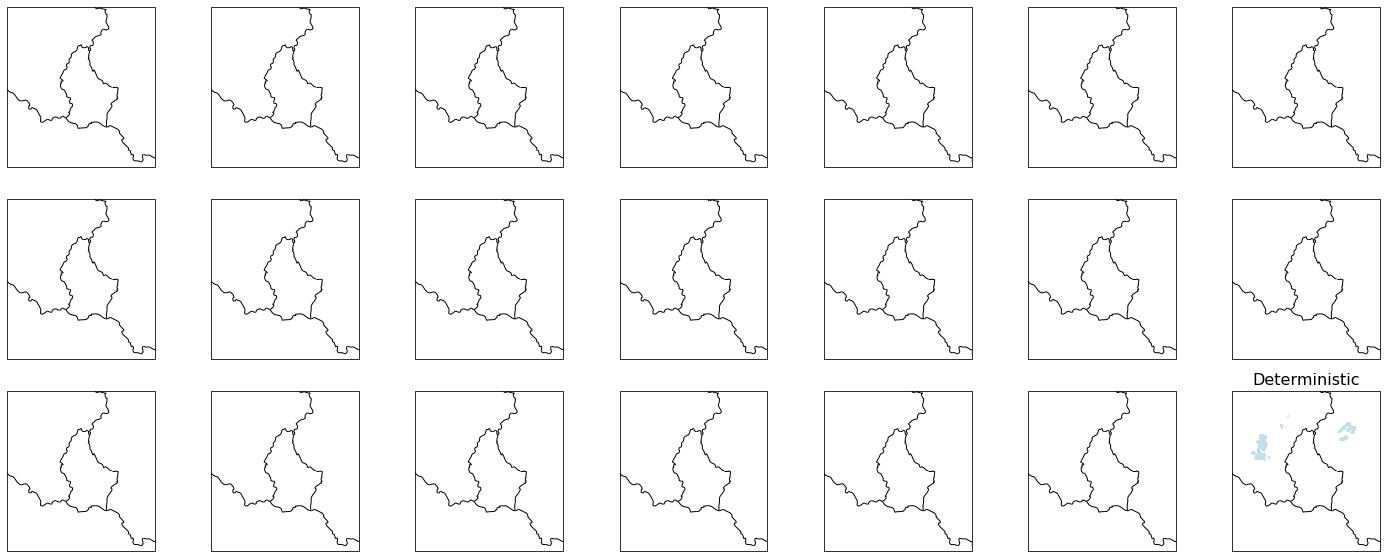

In [7]:
# Create the figure and plot background on different axes
for i in range(1,49):
    
    timestep=timeinit+timedelta(hours=i)
    crs = ccrs.Mercator()
    
    fig, axarr = plt.subplots(nrows=3, ncols=7, figsize=(25, 10), constrained_layout=False,
                              subplot_kw={'projection': crs})

    axlist = axarr.flatten()
    for ax in axlist:
        plot_background(ax)
        
    time2 = data_det_snow['sde'].metpy.time
    #clevs_dbz = np.arange(-2.5,72.5,2.5)
    #clevs_uh = np.arange(0,650,50)
    clevs_snow = np.arange(0,40,2)
    # cmap = plt.get_cmap('gist_ncar')
    # newcmap = ListedColormap(cmap(np.linspace(0.15, 0.9, 30)))
    
    cf1 = axlist[20].contourf(data_det_snow.longitude, data_det_snow.latitude, det_snow.metpy.loc[{'time': time2[i-1]}]*100, 
                         [0,0.1,0.5,1,3,5,10,15,20,25,30,35,40], cmap=newcmap5, norm=norm,  extend='max',transform=ccrs.PlateCarree())
    #ccf1= axlist[20].contour(data_det_vmax.longitude, data_det_vmax.latitude, det_gust.metpy.loc[{'time': time2[i-1]}]*3.6,
                     #[50,70,90,110], colors='black', linestyles='dotted', linewidths=1, transform=ccrs.PlateCarree())
    #try:
        #axlist[20].clabel(ccf1,fontsize=8, inline=1, inline_spacing=3, fmt='%i',  rightside_up=True)
    #except:
        #print('error')
    axlist[20].set_title('Deterministic', fontsize=16)

    for j in range(0,20):
    
        # Upper left plot
        cf1 = axlist[j].contourf(data_snow.longitude, data_snow.latitude, snow.metpy.loc[{'step': time[i], 'number': member[j-1]}]*100, 
                          [0,0.1,0.5,1,3,5,10,15,20,25,30,35,40], cmap=newcmap5, norm=norm,  extend='max', transform=ccrs.PlateCarree())
        #ccf1= axlist[j].contour(data_gust.longitude, data_gust.latitude, vmax.metpy.loc[{'step': time[i], 'number': member[j]}]*3.6,
                         #[50,70,90,110],  colors='black', linestyles='dotted', linewidths=1, transform=ccrs.PlateCarree())
        #try:
            #axlist[j].clabel(ccf1,fontsize=8, inline=1, inline_spacing=3, fmt='%i',  rightside_up=True)
        #except:
            #print('error')
        axlist[j].set_title('Member '+str(j+1), fontsize=16)
        #cb1= fig.colorbar(cf1, ax=axlist[j], orientation='vertical',
                                  #shrink=1, fraction=0.03, pad=0)
        #cb1.set_label('dBZ', size='x-large')



    # Set height padding for plots
    fig.set_constrained_layout_pads(w_pad=0., h_pad=10, hspace=0., wspace=0.)
    cb = fig.colorbar(cf1, ax=axarr.ravel().tolist(), orientation='vertical',
                      ticks=(0,0.1,0.5,1,3,5,10,15,20,25,30,35,40), fraction=0.03, aspect=30, pad=0.02)
    cb.set_label('cm', size='x-large')
    # Set figure title
    plt.gcf().text(0.135, 0.98, 'Model: ICON-D2-EPS 0.02° | ' + timeinit.strftime('Init: %d.%m.%Y %H:%M UTC | ')+timestep.strftime('Valid: %d.%m.%Y %H:%M UTC'), fontsize=20)
    plt.gcf().text(0.135, 0.94, 'Parameter: Snow Depth', fontsize=20)
    #plt.gcf().text(0.6, 0.94, timeinit.strftime('Init: %d.%m.%Y %H:%M UTC / ')+timestep.strftime('Valid: %d.%m.%Y %H:%M UTC'), fontsize=20)
    #plt.gcf().text(0.55, 0.09, 'Note: Updraft helicity is vertically averaged between 500 and 6000 m AGL.', fontsize=10)

    # Display the plot
    time2 = str(i*1)
    base_filename='icond2eps_snow_'
    suffix='.jpeg'
    latest='latest'
    my_file = base_filename+time2+suffix
    print(my_file)
    plt.savefig(my_file, format="jpeg", bbox_inches='tight', dpi=90)
    plt.close(fig)